# OTU plotting module heatmaps DEV v3.14

#### Revised heatmap functions  -v 3.12 dev of guild barplots
- v.3.12 cleans 3.11
- v3.11 from 3.10 adds log2 abundance heatmap, recolors heatmaps
- v3.10 from 3.9 moves up factor level fixes
- v3.9 from 3.8 FIXES heatmap factor levels, but leaves below
- v3.8 from 3.7 cleans up guild plotting non-functions
- v3.7 from 3.6
    - REMOVES guild calculations, replaces with module (functions within)
    - REMOVES heatmap.2 heatmaps, only use ggplot functions
    
TODO:
deal with factor ordering issues inside rankCorr and taxCorr heatmaps

In [1]:
# Import packagaes
suppressMessages(library(Hmisc))
library(ggplot2)
library(RColorBrewer)
library(reshape2)
suppressMessages(library(cowplot))
theme_set(theme_grey())              # important, ggplot2 default overwrites cowplot defaults, which add unwanted items to plots

# Heatmap module outline


### 1) Show rank corrs on heatmap, w/ site colors 
    a) Get data for heatmap of corrRanks                 Tax_corrU_r <- ggHeat_corrRanks_data(Taxons3d, Tax_corrU)
    b) Plot corrRanks heatmap function                   heatmap_corrRanks(Tax_corrU_r, "PiYG")
    c) Get taxonomy color bar data                       Color_bar_d <- TaxColorBar_dat(Taxons3d, Tax_corrU) 
    d) Plot taxonomy color bar                           plot_TaxColorbar(Color_bar_d)
    e) Combine Heatmap and Taxon color bar plot          Tax_heat_corrRanks(Taxons3d, Tax_corrU, "PiYG")    

# Load data for testing

In [2]:
# Read import module for testing convenience here, still a bit of mucking around in pre-processing
source("Import_SalOTU_dat_Plot_test_v0.1.R")

In [3]:
# Reimport color legend from barplots
Taxons3d <-read.table("Test_taxonomy_color_pallete.txt", sep="\t", header = T)
# head(Taxons3d)

### Generate separate Delta sites metadata

In [4]:
# Separate Delta Sites (oligo and FW)
levels(Meta_iTag$SALTgroup)
Meta_iTag_FW <- Meta_iTag[Meta_iTag$SALTgroup =="FW",]
Meta_iTag_Oligo <- Meta_iTag[Meta_iTag$SALTgroup =="Oligo",]

Meta_iTag_Delta <-rbind(Meta_iTag_FW, Meta_iTag_Oligo)
# Meta_iTag_Delta

Delta_sites <-data.frame(Meta_iTag_Delta[,"Sample"])                 # DF of Delta sites
colnames(Delta_sites) [1] <- "Sample"                                # Rename column "Sample"
Delta_sites["Samp_Index"] <- seq(1:nrow(Delta_sites))                # Make sample index for reordering post-merges
#Delta_sites

[1] "FW"    "Meso"  "Oligo" "Poly"

### Function for OTU sample subsetting

In [5]:
# get OTU sample subset function
Samp_subset_OTU = function(otu_V, Samp_subset) { 
# Separate data and taxonomy columns
    Count_cols <- sapply(otu_V, is.numeric)                               # are columns numeric?
    Tax_cols <- otu_V[!Count_cols]                                        # Get Taxonomy columns  dim(Tax_cols)  # head(Tax_cols)
    otu_d <- data.frame(otu_V[Count_cols])                                # Get count data (Sample) columns   

    # Subset data columns by Sample subset, using merge on transp.        # Passing column list didn't work, why?
    otu_dT <-data.frame(t(otu_V[Count_cols]))                             # transp. counts and DF 
    otu_dT["Sample"] <- row.names(otu_dT)                                 # Make sample column 
    otu_SubsetT <- merge(Samp_subset, otu_dT)                             # Merge with subset of samples 
    otu_SubsetT <- otu_SubsetT[order(otu_SubsetT["Samp_Index"]),]         # Sort by Sample Index

    # Retranspose and cbind Taxonomy data
    row.names(otu_SubsetT) <- otu_SubsetT[,"Sample"]                      # replace rownames w. Sample names (pre-transp.)
    otu_SubsetT <- otu_SubsetT[3:ncol(otu_SubsetT)]                       # Drop first two cols (Sample, Samp_Index from merge)
    otu_Subset_d <-data.frame(t(otu_SubsetT))                             # Transpose to OTU table               #dim(otu_Delta_d) #head(otu_Delta_d)
    otu_Subset <- cbind(otu_Subset_d, Tax_cols)                           # add back Taxonomy data
    return(otu_Subset)
}

In [6]:
# Subset Delta smaples from OTU table
Delta_OTU <- Samp_subset_OTU(otu_V, Delta_sites)
#head(Delta_OTU)

### Data import includes Tax_Rank_corr data files, generated like this

In [7]:
## A) Recalculate corr METHODS for controller, using functions from correlations module:
# source("Corr_ranks_module_v0.3.2_strip.R")

# Only to genus level:
# CH4corrRanks <- corr_TaxRanks(otu_V, Meta_iTag, "CH4_logn1")                                  # head(CH4corrRanks)

# Append corrs at OTU level --  SLOW (10 min), need only for iTol? 
# OTU_ra <-append_OTU_corr_v(otu_V, CH4corr_ranks, "CH4_logn1")            

# For Delta samples subset
# CH4corrRanks_Delta_OTU <-append_OTU_corr_v(Delta_OTU, CH4corrRanks_Delta, "CH4_logn1")   
# head(CH4corrRanks_Delta_OTU)

# typically saved to file
# write.table(OTU_ra, "CH4_TaxRankOTU_corr_tab_all_sites.txt", sep="\t", col.names = TRUE, row.names = FALSE, quote=FALSE)
# write.table(CH4corrRanks_Delta_OTU, "CH4_TaxRankOTU_corr_tab_Delta_sites.txt", sep="\t", col.names = TRUE, row.names = FALSE, quote=FALSE)

## B) Read EXISTING corr table: 
# CH4corrRanksOTU <-read.table("CH4_TaxRankOTU_corr_tab_all_sites.txt", sep="\t", header=T)      #head(CH4corrRanksOTU)

## C) Read EXISTING Delta corr table: 
# CH4corrRanksOTU_Delta <-read.table("CH4_TaxRankOTU_corr_tab_Delta_sites.txt", sep="\t", header=T)  #head(CH4corrRanksOTU_Delta)


# FUNCTIONS defined below for heatmaps
# __________________________________________________________________________

## copied from Barplots functions: 
## 5.a) Merges existing colors with OTU table, creating "other" category

In [8]:
ColorMap_other = function(Taxons3d, otu_V){  #, tax_sort = "Consensus.lineage"){ # Revised v.3.5
    
    rankvar <-colnames(Taxons3d)[1]                                             # Get taxonomic rank from Palette -v3.3
    
    # Drop "Other" rows and merge with OTU table
    Taxons3dx <- Taxons3d[1:nrow(Taxons3d)-1,]                                  # drop "Other" entirely, assuming last col   #Taxons3dx
    TaxCol_otu <- merge(Taxons3dx, otu_V, all.y=TRUE)                           # Merge with otu_table, while keeping all of OTU table.  #Tax_col_otu 

    # get last Tax order and color, corresponding to "Other"
    Indx <- Taxons3d[,'Index']                                                  # get color pal index
    colr <- Taxons3d[,'color']                                                  # get color pal colors  
    Taxa <- Taxons3d[,rankvar]
    last_order <- Indx[nrow(Taxons3d)]                                          # get last index number, for "Other"
    last_color <- colr[nrow(Taxons3d)]                                          # get last color, for "Other"      # last_order
    last_Taxa <- as.character(Taxa[nrow(Taxons3d)])
    
    # Test for other before NA replace
    Other_test <- "Other" %in% Taxons3d[,rankvar]                               # Is "Other in original pal
    ifelse(Other_test == TRUE, Other_var <-"Other", Other_var <- last_Taxa)     # Generate Other_var 
    
    # Replace NAs in Order, Tax, and Color, by ifelse, recode new vars: 
    TaxCol_otu["newOrder"] <- ifelse(is.na(TaxCol_otu[,"Index"] == TRUE), last_order, TaxCol_otu[,'Index']) 
    TaxCol_otu["newTax"] <- ifelse(is.na(TaxCol_otu[,"Index"] == TRUE), paste(Other_var), paste(TaxCol_otu[,rankvar]))    # newTax, if < min, "Other"
    TaxCol_otu["newColor"] <- ifelse(is.na(TaxCol_otu[,"color"] == TRUE), paste(last_color), paste(TaxCol_otu[,'color']))

    # Reorder factor levels by Index
    TaxCol_otu["newTax"] <- reorder(TaxCol_otu[,"newTax"], TaxCol_otu[,"newOrder"])       # reorder factors by index..
    TaxCol_otu["newColor"] <- reorder(TaxCol_otu[,"newColor"], TaxCol_otu[,"newOrder"])   # ...needed below...
    TaxCol_otu$newOrder <- reorder(TaxCol_otu$newOrder, TaxCol_otu$newOrder)              # index as factor ""

    TaxCol_otu <- TaxCol_otu[order(TaxCol_otu[,"Index"]),]                                # sort by index     
    return(TaxCol_otu)
}

In [9]:
# Test function
otuTaxCol <-ColorMap_other(Taxons3d, otu_V)              #
# otuTaxCol <-ColorMap_other(Taxons3d, otu_agg)
#head(otuTaxCol)  

# \*\*\* [ ggplot 2 approach to heatmaps ] \*\*\*

In [10]:
# Prepare data 

In [11]:
# Drop OTU vars or heatmap will never render
CH4corrRanks <-CH4corrRanksOTU[,1:(ncol(CH4corrRanksOTU)-2)]           # if need be, drop OTU data for unique at genus / Consensus.lineage
Tax_corrU <- unique(CH4corrRanks)                                      # get only unique rows                  
 # dim(Tax_corrU); head(Tax_corrU)  # unique(Tax_corrU$Taxonomy)

# 1) Show rank corrs on heatmap, w/ site colors 

## 1a) Get data for heatmap of corrRanks

In [12]:
ggHeat_corrRanks_data = function(Taxons3d, Tax_corrU, tax_sort="Consensus.lineage") {                       # uses colorMap_other function 
                                                                              #  add row_var, Tax_sort?
    ## Input data using colorMap function
    TaxCol_otu <-ColorMap_other(Taxons3d, Tax_corrU)                          # get Colormap merged corrRanks 
    TaxCol_otu <-TaxCol_otu[rev(order(TaxCol_otu[,tax_sort])),]    # sort by Cons.lin, rev for stacked bar
    row.names(TaxCol_otu) <- make.unique(as.character(TaxCol_otu[,"Genus"]))  # Make unique rownames for genera


    # Get only count data from OTU color table
    Count_cols <- sapply(TaxCol_otu, is.numeric)                               # are columns numeric?
    TaxCol_otu_d <-TaxCol_otu[Count_cols]                                      # get df with only numeric columns
    TaxCol_otu_d <-TaxCol_otu_d[,-1]                                           # drops Index

    # get heatmap plotting data
    Tax_corrU_r <-data.matrix(TaxCol_otu_d[,2:6])                              # select Tax Ranks to display
    #return(TaxCol_otu)
    return(Tax_corrU_r)
}

In [13]:
# Apply function test
Tax_corrU_r <-ggHeat_corrRanks_data(Taxons3d, Tax_corrU)

In [14]:
#head(Tax_corrU_r)

## 1b) Plot corrRanks heatmap function

In [15]:
heatmap_corrRanks = function(Tax_corrU_r, heat_cols = def_cols, ylab=F, xlab=T) {

    # Melt data for ggplot                                                                 # here if compositing subsets
    Tax_corrU_r_Melt<- melt(Tax_corrU_r)                                                   # Melt data
    colnames(Tax_corrU_r_Melt)[3] <- "Correlation"                                         # name corr. col "Correlation"

    # Get colors from heatmap
    def_cols<-c("steelblue", "white", "darkred")    
     
    # Make ggplot heatmap
    p <- ggplot(Tax_corrU_r_Melt, aes(Var2, Var1)) + geom_tile(aes(fill=Correlation)) + 
          scale_fill_gradientn(colours=heat_cols, na.value = "white") +  
          #scale_fill_gradientn(colours=heat_cols)                              +            # Fill with heat_cols  #breaks = c(-0.6,-0.3, 0, 0.3, 0.6),  # guide="legend"   

         # Axis params
         theme(axis.title.y = element_blank())                                +            # hide y axis title  
         scale_y_discrete(position="right")                                   +            # y labs to right
         theme(axis.title.x = element_blank())                                +            # hide x axis title                      
         scale_x_discrete(position = "top")                                   +            # x labs on top
         theme(axis.text.x = element_text(angle = 90, hjust = 1))             +            # rotate x labs 
         
         # Panel params
         theme(panel.background = element_blank(),                                         # Remove panel borders 
           panel.grid.major = element_blank(),                                             # and grid lines  
           panel.grid.minor = element_blank())                                +            # Remove legend entirely
     
         # Legend params
         theme(legend.position = "bottom")                                    +            # legend on bottom
         theme(legend.title = element_blank())                                             # no legend title
        
         ifelse(ylab==T, p <- p,                                                           # hide y labels ? 
                p <- p + theme(axis.text.y=element_blank(),axis.ticks.y=element_blank()))
         ifelse(xlab==T, p <- p,                                                           # hide y labels ? 
                p <- p + theme(axis.text.x=element_blank(),axis.ticks.x=element_blank()))
 
    p
}

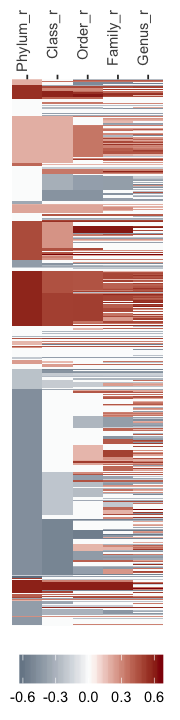

In [16]:
# Test function
options(repr.plot.width=1.5, repr.plot.height=6) 
#dim(Tax_corrU_r)

# Define heatmap colors -- defaults to slateblue-> red
grey_red <- c("slategray","white","red4")

heatmap_corrRanks(Tax_corrU_r, heat_cols=grey_red)       # Don't need to define heat_cols, but can
                                                         # Can also use y_lab=T to get Genus names   

## 1c) Get taxonomy color bar data 

In [17]:
TaxColorBar_dat = function(Taxons3d, Tax_corrU, tax_sort="Consensus.lineage"){
                                                 
    # Get genus scale Taxonomy color data, from using colorMap_other merge 
    TaxCol <-ColorMap_other(Taxons3d, Tax_corrU)                                    # Colormap filtered corrRanks 
    TaxCol <-TaxCol[rev(order(TaxCol[,tax_sort])),]                      # sort by Consensus.lineage, reverse for bar stacking

    # Slice Taxonomy, color data 
    keep_cols <-c("newTax", "newColor")                                    # Get columns to keep from TaxColors, for plotting

    #keep_cols <-c("newTax", "Index", "newColor")                                    # Get columns to keep from TaxColors, for plotting
    Color_bar_d <- TaxCol[,keep_cols]                                               # data, only Keep cols   
    colnames(Color_bar_d)[1] <- "Taxonomy" 

    # Plotting data, y, x, colors 
    Color_bar_d["Genus"] <- as.factor(make.unique(rownames(TaxCol)))                # "y": Get genus names from rownames 
    Color_bar_d["Gen_ind"] <- seq(1:nrow(Color_bar_d))                              # Make sequential genus names to reorder factor
    Color_bar_d["Genus"] <- reorder(Color_bar_d[,"Genus"], Color_bar_d[,"Gen_ind"]) # reorder "y" factor by index
    Color_bar_d["counts"] <- 1                                                      # "x": Fake 1 counts for barplot 
    return(Color_bar_d)
}

In [18]:
# Use TaxColorBar_dat function 
Color_bar_d <- TaxColorBar_dat(Taxons3d, Tax_corrU)

#Color_bar_d <- TaxColorBar_dat(Taxons3d, Corr_filt_r)
head(Color_bar_d)

,Taxonomy,newColor,Genus,Gen_ind,counts
721,Other,#999999,721,1,1
633,WS3,#BC8FA7,633,2,1
632,WS3,#BC8FA7,632,3,1
631,WS3,#BC8FA7,631,4,1
634,WS3,#BC8FA7,634,5,1
629,WS3,#BC8FA7,629,6,1


## 1d) plot taxonomy color bar

In [19]:
plot_TaxColorbar = function(Color_bar_d, ylab=F){
    
    # Get colors from levels
    Tax_colU <-levels(Color_bar_d[,"newColor"]) 

    # Make barplot using geom_tile method
    t <-ggplot(Color_bar_d, aes(x=counts, y=Genus, fill=Taxonomy))                            # fill loc. 
    t2 <- t + geom_tile(position="identity", alpha = 0.85) + scale_fill_manual(values=c(Tax_colU))           + # manual fill col2
          
          # Axis params      
          theme(axis.title.x=element_blank(), axis.text.x=element_blank(), axis.ticks.x=element_blank()) + # Remove x labs
          theme(axis.title.y=element_blank()) +#, axis.text.y=element_blank(), axis.ticks.y=element_blank()) + # Remove y labs
          
          # Panel params
          theme(panel.background = element_blank(),                                           # Remove panel borders and grid lines  #
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank())                                              +
          
          # Legend params   
          theme(legend.position="left")          +
          theme(legend.key.size = unit(0.5, "cm"))                                         +   # Shrink legend
          guides(fill = guide_legend(ncol=1))                                                  # 1 col legend
    
          ifelse(ylab==T, t2 <- t2,                                                           # hide y labels ? 
                t2 <- t2 + theme(axis.text.y=element_blank(),axis.ticks.y=element_blank()))
  
    t2 
}

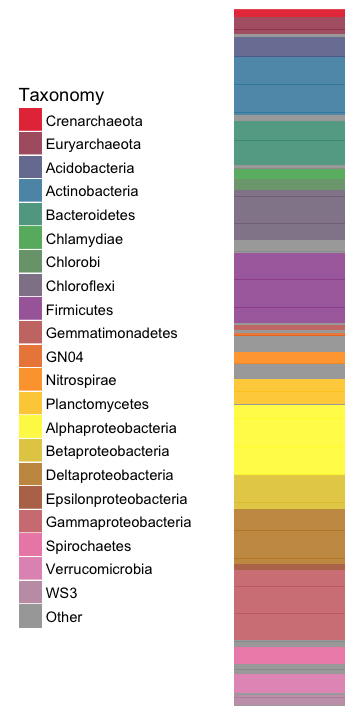

In [20]:
# Note artifacts from using alpha = 0.8 above, or any alpha-- can erase but colors not matching orig...

# use plot_TaxColorbar function
options(repr.plot.width=3, repr.plot.height=6) 
plot_TaxColorbar(Color_bar_d)

# 1e) combine Heatmap and Taxon color bar plot

In [21]:
Tax_heat_corrRanks = function(Taxons3d, Tax_corrU, heat_cols=default){           # uses cowplot::plot_grid 

    # Get heatmap of corrRanks
    Tax_corrU_r <- ggHeat_corrRanks_data(Taxons3d, Tax_corrU)           # use function to get corrRanks data
    heatRanks <- heatmap_corrRanks(Tax_corrU_r, heat_cols)                 # plotting function for heatmap of corrRanks

    # Get Taxonomy colorBar
    Color_bar_d <- TaxColorBar_dat(Taxons3d, Tax_corrU)                 # use function to get Tax colorBar data 
    TaxColors <- plot_TaxColorbar(Color_bar_d)                          # plotting function for Tax colorBar

    # Split Taxononmy colorBar into no-legend; legend
    TaxColors_NL <- TaxColors + theme(legend.position="none")
    TaxColors_Legend <-get_legend(TaxColors)

    # Composite plotting of components
    pg_hm <- plot_grid(TaxColors_NL, heatRanks, align="h", ncol=2, rel_widths = c(1,3), axis = "rlbt") 
    pg_hmL <- plot_grid(pg_hm, TaxColors_Legend, ncol=2, rel_widths = c(1.3, 2))#, axis = "rlbt")  align="h"
    return(pg_hmL)
}

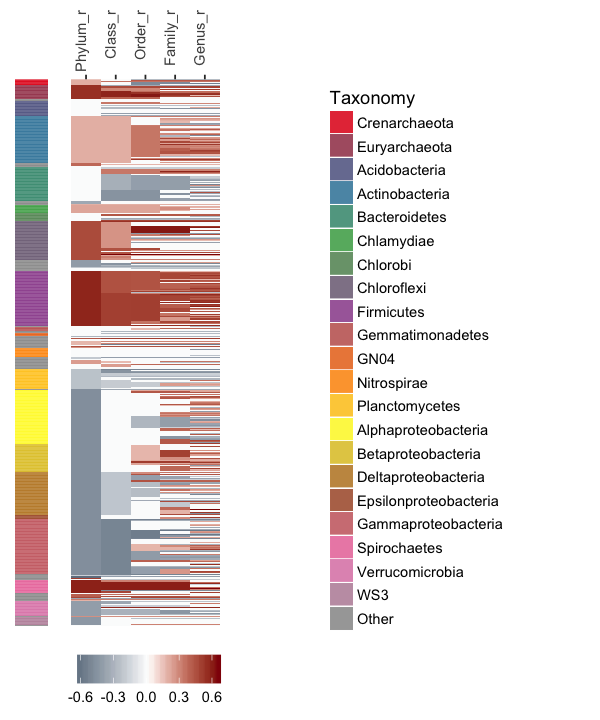

In [22]:
# Test corrRanks heatmap w taxon color bar
options(repr.plot.width=5, repr.plot.height=6) 
Tax_heat_corrRanks(Taxons3d, Tax_corrU, heat_cols=grey_red)               # grey_red <- c("slategray","white","red4")
                                                                          # heat_cols has default

In [23]:
ggsave('CH4_otu_corrheatmapUMX_0.1.pdf')

Saving 7 x 7 in image


# 2) Get corrRank data filtered by correlation cutoff 

In [24]:
corrRanks_filt = function(otu_V, corrRanks, rank_var, r_cut){          # Simplified from v.3.1

    #corrRanks <- CH4corrRanksOTU_Delta 
    #chunk_var <- "Genus"
    rank_r <- paste0(rank_var,"_r")
    abs_rank_r <-paste0("abs_", rank_r)
    #r_cut <- 0.5

    # Get abs val of ranks
    corrRanks[abs_rank_r] <-abs(corrRanks[,rank_r])

    # Get corr filtered ranks 
    corrRanks_F <- corrRanks[corrRanks[,abs_rank_r] > r_cut,]         
    corrRanks_F <- corrRanks_F[,1:(ncol(corrRanks_F)-1)]
    row.names(corrRanks_F) <-  make.unique(as.character(corrRanks_F[,rank_var]))  # Rename rows
    return(corrRanks_F)
    
    
    # Select column of interest, make DF
    #r_Filt_rank <-data.frame(corrRanks_F[, rank_var])
    #colnames(r_Filt_rank)[1] <- rank_var
    #r_Filt_rank[rank_r]<-corrRanks_F[,rank_r]
    #return(r_Filt_rank)
    return(corrRanks_F)
}


In [25]:
# Test corrRanks_Filt function

# prepare data 
corrRank_OTU <- CH4corrRanksOTU_Delta
corrRank_gU <-unique(corrRank_OTU[1:(ncol(corrRank_OTU)-3)])                     # Drop OTU data, Taxonomy corr...   # remove last 3 cols: OTU and Tax corr

# Use corrRanks_Filt function
Corr_filt_r <- unique(corrRanks_filt(otu_V, corrRank_gU, "Genus", 0.5))
# dim(Corr_filt_r); head(Corr_filt_r)

## Plot of corr_filtered heatmap only

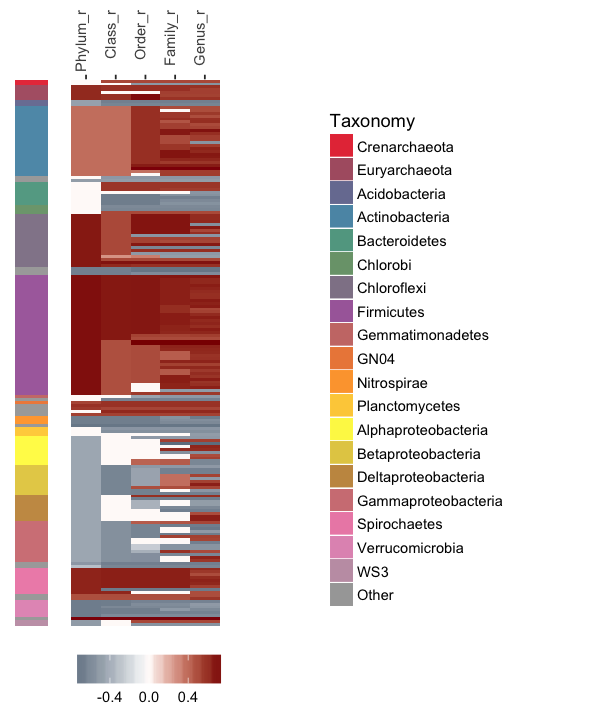

In [26]:
# Test plot of corr_filtered heatmap only
# Test corrRanks heatmap w taxon color bar

options(repr.plot.width=5, repr.plot.height=6) 
Tax_heat_corrRanks(Taxons3d, Corr_filt_r, heat_cols = grey_red)               # or ("RdGy")

# break components
# Get heatmap of corrRanks
# Tax_corrU_r <- ggHeat_corrRanks_data(Taxons3d, Corr_filt_r)           # use function to get corrRanks data
#heatRanks <- heatmap_corrRanks(Tax_corrU_r, heatcols)                 # plotting function for heatmap of corrRanks

# Get Taxonomy colorBar
#Color_bar_d <- TaxColorBar_dat(Taxons3d, Corr_filt_r)                 # use function to get Tax colorBar data 
#TaxColors <- plot_TaxColorbar(Color_bar_d)                          # plotting function for Tax colorBar


# 3) Get guild data for guild heatmap

In [27]:
# Import OTU_subsetting_modules
# This includes a function for getting a guild to OTU mapping:

#### Test get guilds function
# Guild_OTUs <- Get_16S_Guilds(otu_V)

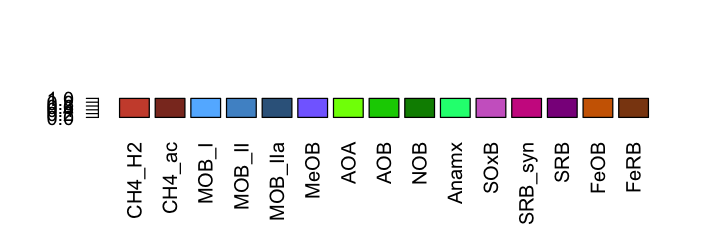

In [28]:
source("OTU_subsetting_modules_v.0.2_strip.R")
# options(repr.plot.width=1.5, repr.plot.height=6) 

### Use Get Guilds function to obtain a list of Guild OTUs

In [29]:
Guild_OTUs <- Get_16S_Guilds(otu_V)
# dim(Guild_OTUs); head(Guild_OTUs)

In [30]:
# Note this module comes with a list of colors, 
# which can also be retrived from the file "Guild_color_palette.txt"
head(Guild_colors)

Guild,color,G_index
CH4_H2,#CD4F39,1
CH4_ac,#8B3626,2
MOB_I,#63B8FF,3
MOB_II,#4F94CD,4
MOB_IIa,#36648B,5
MeOB,#836FFF,6


# Get data for guild color bar

### merge guild OTUs and taxonomy info 
to get guild color and sort data 

In [31]:
# Make guild vector for all OTUs
Guild_color_data = function(Guild_OTUs, Guild_colors, otu_t, sort_tax ="Consensus.lineage", agg_tax="Genus") {

    # Get OTU, consensus lineage from input OTU table
    # otu_t <- otu_V                                                              # abstraction for function
    # keep_cols <-c("Consensus.lineage", "Genus")                                 # keep Consens. Lineage and Genus   
    keep_cols <-c(sort_tax, agg_tax)                                 # keep Consens. Lineage and Genus   
    All_OTUs <- otu_t[keep_cols]                                                # keep " in input OTU table
    All_OTUs["OTU"]<-row.names(All_OTUs)   #All_OTUs                            # get OTU Ids from rownames

    # Merge OTU data with Guilds and Guild colors
    Allotu_Guilds <- merge(All_OTUs, Guild_OTUs, all.x =TRUE)                   # Merge Guilds with all OTUs
    Allotu_Guilds_colors <- merge(Allotu_Guilds, Guild_colors, all.x=TRUE)      # Merge with Guild color palette

    # Replace missing colors (NA from merge)
    Allotu_Guilds_colors["G_color"] <- ifelse(is.na(Allotu_Guilds_colors$color)==TRUE,    
        "#FFFFFF", as.character(Allotu_Guilds_colors$color)) 

    # drop OTUs in Guild data, Get genus level data
    Guild_d <-c("Guild", "G_color","Consensus.lineage", "Genus")                          # get columns to keep
    Guild_bar_d <- Allotu_Guilds_colors[Guild_d]                                          # seletct columns  
    Guild_bar_dU <- unique(Guild_bar_d)                                                   # get unique at Genus

    # Prepare data for plot
    Guild_bar_dU["counts"] <- 1
    return(Guild_bar_dU)
}    

In [32]:
# Test Guild color data function, 
# note sort_tax and agg_tax are defaults to sort on, and level of aggregation used
Guild_bar_dU <- Guild_color_data(Guild_OTUs, Guild_colors, otu_V, sort_tax ="Consensus.lineage", agg_tax="Genus")
head(Guild_bar_dU)

,Guild,G_color,Consensus.lineage,Genus,counts
1,CH4_H2,#CD4F39,k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__MethanobacterialesOR;g__MethanobacterialesOR,MethanobacterialesOR,1
3,CH4_H2,#CD4F39,k__Archaea;p__Euryarchaeota;c__Methanomicrobia;o__Methanomicrobiales;f__MethanomicrobialesOR;g__MethanomicrobialesOR,MethanomicrobialesOR,1
4,CH4_H2,#CD4F39,k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales,MethanobacterialesOR,1
6,CH4_H2,#CD4F39,k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__WSA2;g__WSA2FA,WSA2FA,1
7,CH4_H2,#CD4F39,k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobacterium,Methanobacterium,1
11,CH4_H2,#CD4F39,k__Archaea;p__Euryarchaeota;c__Methanomicrobia;o__Methanocellales;f__Methanocellaceae;g__Methanocella,Methanocella,1


### Merge guild color info with TaxCorr object

In [33]:
# Merge guild bar data with TaxCorr object (filtered or unfiltered)
# Plotting below looks to work using Tax_corrU OR Corr_filt_r

Guild_corr_d = function(Guild_bar_d, Tax_corrU) {

    # Merge Guild data with Tax Corr data (here corr filtered)  
    Corr_Guild_d <- merge(Guild_bar_d, Tax_corrU)                                       # merge by Genus

    # Reorder data so Corr_filt_r data is first (for using plotting functions)
    col_order <-c(names(Tax_corrU), names(Guild_bar_d))                                 # Get column ordering 
    Corr_Guild_d <-Corr_Guild_d[col_order]                                              # Reorder columns
    #length(unique(Corr_filt_Guild_d$Genus))

    # make Genus names unique (to match plotting in corrRanks), sort and order Genus factor
    Corr_Guild_d$Genus <- make.unique(as.character(Corr_Guild_d$Genus))                 # Make unique
    Corr_Guild_d <- Corr_Guild_d[rev(order(Corr_Guild_d$Consensus.lineage)),]           # reverse sort by lineage
    Corr_Guild_d["order"] <-seq(1:nrow(Corr_Guild_d))                                   # get Index for Genus factor
    Corr_Guild_d$Genus <- reorder(Corr_Guild_d$Genus, Corr_Guild_d$order)               # Reorder Genus factor by order
    return(Corr_Guild_d)
}

In [34]:
# Test function Guild_corr_d
Corr_Guild_d <- Guild_corr_d(Guild_bar_dU, Tax_corrU)
Corr_filt_Guild_d <- Guild_corr_d(Guild_bar_dU, Corr_filt_r)

# dim(Corr_Guild_d); head(Corr_Guild_d)
dim(Corr_filt_Guild_d); head(Corr_filt_Guild_d)

[1] 187  20

,Consensus.lineage,Kingdom,Phylum,Class,Order,Family,Genus,Taxonomy,Kingdom_r,Phylum_r,Class_r,Order_r,Family_r,Genus_r,Guild,G_color,Consensus.lineage.1,Genus.1,counts,order
187,k__Bacteria;p__WS3;c__PRR-12;o__wb1_H11;f__wb1_H11OR;g__wb1_H11OR,Bacteria,WS3,PRR-12,wb1_H11,wb1_H11OR,wb1_H11OR,WS3,-0.4837669,-0.5165417,0.0000000,-0.5604592,-0.5604592,-0.5604592,NA,#FFFFFF,k__Bacteria;p__WS3;c__PRR-12;o__wb1_H11;f__wb1_H11OR;g__wb1_H11OR,wb1_H11OR,1,1
186,k__Bacteria;p__WS3;c__PRR-12;o__SSS58A;f__SSS58AOR;g__SSS58AOR,Bacteria,WS3,PRR-12,SSS58A,SSS58AOR,SSS58AOR,WS3,-0.4837669,-0.5165417,0.0000000,0.5224713,0.5224713,0.5224713,NA,#FFFFFF,k__Bacteria;p__WS3;c__PRR-12;o__SSS58A;f__SSS58AOR;g__SSS58AOR,SSS58AOR,1,2
185,k__Bacteria;p__WS1;c__WS1PH;o__WS1PH;f__WS1PH;g__WS1PH,Bacteria,WS1,WS1PH,WS1PH,WS1PH,WS1PH,WS1,-0.4837669,0.7417588,0.7417588,0.7417588,0.7417588,0.7417588,NA,#FFFFFF,k__Bacteria;p__WS1;c__WS1PH;o__WS1PH;f__WS1PH;g__WS1PH,WS1PH,1,3
184,k__Bacteria;p__Verrucomicrobia;c__VerrucomicrobiaPH;o__VerrucomicrobiaPH;f__VerrucomicrobiaPH;g__VerrucomicrobiaPH,Bacteria,Verrucomicrobia,VerrucomicrobiaPH,VerrucomicrobiaPH,VerrucomicrobiaPH,VerrucomicrobiaPH,Verrucomicrobia,-0.4837669,-0.6925285,-0.6111934,-0.6111934,-0.6111934,-0.6111934,NA,#FFFFFF,k__Bacteria;p__Verrucomicrobia;c__VerrucomicrobiaPH;o__VerrucomicrobiaPH;f__VerrucomicrobiaPH;g__VerrucomicrobiaPH,VerrucomicrobiaPH,1,4
183,k__Bacteria;p__Verrucomicrobia;c__Verrucomicrobiae;o__Verrucomicrobiales;f__VerrucomicrobialesOR;g__VerrucomicrobialesOR,Bacteria,Verrucomicrobia,Verrucomicrobiae,Verrucomicrobiales,VerrucomicrobialesOR,VerrucomicrobialesOR,Verrucomicrobia,-0.4837669,-0.6925285,-0.6790884,-0.6790884,-0.6611734,-0.6611734,NA,#FFFFFF,k__Bacteria;p__Verrucomicrobia;c__Verrucomicrobiae;o__Verrucomicrobiales;f__VerrucomicrobialesOR;g__VerrucomicrobialesOR,VerrucomicrobialesOR,1,5
182,k__Bacteria;p__Verrucomicrobia;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Verrucomicrobiaceae;g__VerrucomicrobiaceaeFA,Bacteria,Verrucomicrobia,Verrucomicrobiae,Verrucomicrobiales,Verrucomicrobiaceae,VerrucomicrobiaceaeFA,Verrucomicrobia,-0.4837669,-0.6925285,-0.6790884,-0.6790884,-0.5253989,-0.6182314,NA,#FFFFFF,k__Bacteria;p__Verrucomicrobia;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Verrucomicrobiaceae;g__VerrucomicrobiaceaeFA,VerrucomicrobiaceaeFA,1,6


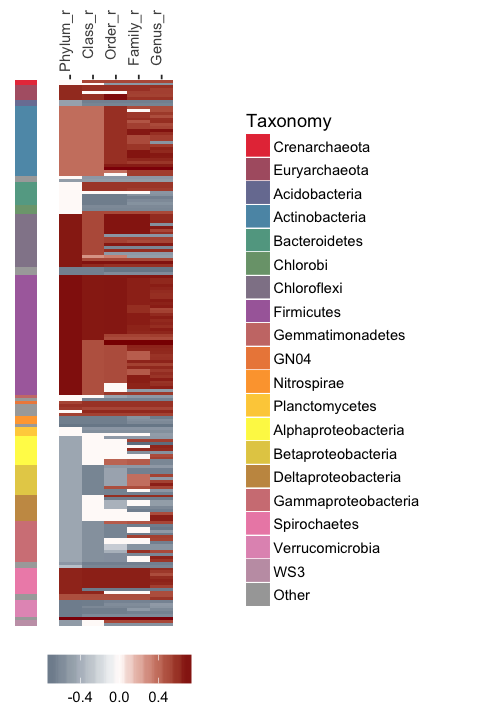

In [35]:
# Does updated dataset work with older functions  -- YES
options(repr.plot.width=4, repr.plot.height=6) 
# Tax_heat_corrRanks(Taxons3d, Corr_Guild_d, "PiYG")
Tax_heat_corrRanks(Taxons3d, Corr_filt_Guild_d, heat_cols=grey_red)
#corr_heat_colorIn(Taxons3d, Corr_filt_Guild_d)

In [36]:
#ggsave('CH4_otu_corrheatmapUMX_0.1.pdf')

## plot guild color bar

## Make guild barplot function

In [37]:
### Make barplot after extracting data from Guild_colr_d

Guild_color_bar = function(Corr_Guild_d){

    # get only guilds and color data from merged data                        # Here not full compliment of guilds 
    keep<- c("Guild", "G_color")                                             # Keep columns
    Guild_colr_d <-Corr_Guild_d[keep]                                   # Filter merged data on keep

    # Merge data with Guild ordering
    Guild_color_O <- unique(merge(Guild_colr_d, Guild_colors, by="Guild"))   # Merge Guild color_d (fewer), Guild_colors
    Guild_color_O <- Guild_color_O[order(Guild_color_O$G_index),]            # Sort by ordering index
    Guild_cols <-Guild_color_O$G_color                                       # Get final colors from ordered

    # Make barplot using geom_tile method
    g <-ggplot(Corr_Guild_d, aes(x=counts, y=Genus, fill=Guild))                            # fill loc. 
    g2 <- g + geom_tile(position="identity", alpha = 0.8) + scale_fill_manual(values=c(Guild_cols))  +   
         # Axis params
         theme(axis.title.y = element_blank(), axis.text.y=element_blank(),                # hide y - axis labels  
                axis.ticks.y=element_blank())                                +
         theme(axis.title.x = element_blank())                                +            # hide x axis title                      
         scale_x_discrete(position = "top") +
         theme(axis.text.x = element_text(angle = 90, hjust = 1))             +

         # Panel params
         theme(panel.background = element_blank(),                                         # Remove panel borders and grid lines  #
           panel.grid.major = element_blank(),
           panel.grid.minor = element_blank())                                #+                                                # Remove legend entirely
     
         # Legend params
         #theme(legend.position = "bottom")                                    + 
         #theme(legend.title = element_blank())
g2
}


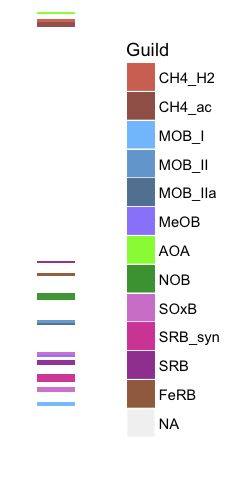

In [38]:
options(repr.plot.width=2, repr.plot.height=4) 
#Guild_color_bar(Corr_Guild_d)
Guild_color_bar(Corr_filt_Guild_d)

# Plot guild color bar with other data 
Sorted out factor levels issue

### Filter data by guilds only after merge with corr only

In [39]:
# FILTER BY IN GUILDS ONLY 
Corr_filt_Guild_Gd <-Corr_filt_Guild_d[!is.na(Corr_filt_Guild_d$Guild), ]   # Filter by guilds non-NA only
#head(Corr_filt_Guild_d)

Corr_filt_Guild_Gd <-Corr_filt_Guild_Gd[order(Corr_filt_Guild_Gd$Guild),]     # Sort df by Guilds 
Corr_filt_Guild_Gd["G_order"]<-rep(1:nrow(Corr_filt_Guild_Gd))               # Make guild ordering index 
#head(Corr_filt_Guild_d)

# reorder genus levels by guild ordering
Corr_filt_Guild_Gd$Genus <- reorder(Corr_filt_Guild_Gd$Genus, rev(Corr_filt_Guild_Gd$G_order))               # Reorder Genus factor by order
dim(Corr_filt_Guild_Gd); head(Corr_filt_Guild_Gd)
#Corr_filt_Guild_Gd

[1] 22 21

,Consensus.lineage,Kingdom,Phylum,Class,Order,Family,Genus,Taxonomy,Kingdom_r,Phylum_r,⋯,Order_r,Family_r,Genus_r,Guild,G_color,Consensus.lineage.1,Genus.1,counts,order,G_order
5,k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__WSA2;g__WSA2FA,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,WSA2,WSA2FA,Euryarchaeota,0.4837669,0.6336296,⋯,0.0000000,0.5526925,0.5526925,CH4_H2,#CD4F39,k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__WSA2;g__WSA2FA,WSA2FA,1,183,1
7,k__Archaea;p__Euryarchaeota;c__Methanomicrobia;o__Methanosarcinales;f__MethanosarcinalesOR;g__MethanosarcinalesOR,Archaea,Euryarchaeota,Methanomicrobia,Methanosarcinales,MethanosarcinalesOR,MethanosarcinalesOR,Euryarchaeota,0.4837669,0.6336296,⋯,0.7208129,0.5987860,0.5987860,CH4_ac,#8B3626,k__Archaea;p__Euryarchaeota;c__Methanomicrobia;o__Methanosarcinales;f__MethanosarcinalesOR;g__MethanosarcinalesOR,MethanosarcinalesOR,1,181,2
6,k__Archaea;p__Euryarchaeota;c__Methanomicrobia;o__Methanosarcinales;f__Methanosaetaceae;g__Methanosaeta,Archaea,Euryarchaeota,Methanomicrobia,Methanosarcinales,Methanosaetaceae,Methanosaeta,Euryarchaeota,0.4837669,0.6336296,⋯,0.7208129,0.5444417,0.5444417,CH4_ac,#8B3626,k__Archaea;p__Euryarchaeota;c__Methanomicrobia;o__Methanosarcinales;f__Methanosaetaceae;g__Methanosaeta,Methanosaeta,1,182,3
161,k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Methylococcales;f__MethylococcalesOR;g__MethylococcalesOR,Bacteria,Proteobacteria,Gammaproteobacteria,Methylococcales,MethylococcalesOR,MethylococcalesOR.1,Gammaproteobacteria,-0.4837669,-0.4560072,⋯,-0.2597136,-0.5532395,-0.5532395,MOB_I,#63B8FF,k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Methylococcales;f__MethylococcalesOR;g__MethylococcalesOR,MethylococcalesOR,1,27,4
160,k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Methylococcales,Bacteria,Proteobacteria,Gammaproteobacteria,Methylococcales,MethylococcalesOR,MethylococcalesOR,Gammaproteobacteria,-0.4837669,-0.4560072,⋯,-0.2597136,-0.5532395,-0.5532395,MOB_I,#63B8FF,k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Methylococcales,MethylococcalesOR,1,28,5
127,k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Methylobacteriaceae;g__Methylobacterium,Bacteria,Proteobacteria,Alphaproteobacteria,Rhizobiales,Methylobacteriaceae,Methylobacterium,Alphaproteobacteria,-0.4837669,-0.4560072,⋯,0.0000000,0.6233143,0.6233143,MOB_II,#4F94CD,k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Methylobacteriaceae;g__Methylobacterium,Methylobacterium,1,61,6


In [40]:
dim(Corr_filt_Guild_d)

[1] 187  20

## Plot guilds along with taxonomy and rankCorr

In [41]:
## IMPORTANT, here reorder ALL by G_order (cell above) -- Guild ordering,
## by overriding default tax_sort = "Consensus.lineage in corrRanks and Tax colorBar plots

#Tax_heat_corrRanks = function(Taxons3d, Tax_corrU, heatcols){      # uses cowplot::plot_grid 


# Tax_corrU <- Corr_filt_Guild_d
 heat_cols <-grey_red
 #heatcols <- "PiYG"; # heatcols <- "RdGy"

# Get heatmap of corrRanks
Tax_corrU_r <- ggHeat_corrRanks_data(Taxons3d, Corr_filt_Guild_Gd, tax_sort="G_order")           # use function to get corrRanks data
heatRanks <- heatmap_corrRanks(Tax_corrU_r, heat_cols, ylab=T)       # plotting function for heatmap of corrRanks

# Get Taxonomy colorBar
Color_bar_d <- TaxColorBar_dat(Taxons3d, Corr_filt_Guild_Gd, tax_sort="G_order")                 # use function to get Tax colorBar data 
TaxColors <- plot_TaxColorbar(Color_bar_d)                          # plotting function for Tax colorBar

# Split Taxononmy colorBar into no-legend; legend
TaxColors_NL <- TaxColors + theme(legend.position="none")
TaxColors_Legend <-get_legend(TaxColors)

# Get guilds bar
Guild_bar <- Guild_color_bar(Corr_filt_Guild_Gd)
Guild_bar_NL <- Guild_bar + theme(legend.position="none")
Guild_bar_Legend <-get_legend(Guild_bar)

# Composite plotting of components
pg_hm <- plot_grid(Guild_bar_NL, TaxColors_NL, heatRanks, align="h", ncol=3, rel_widths = c(1,0.7,4), axis = "rlbt") 
legends <- plot_grid(Guild_bar_Legend, TaxColors_Legend, ncol=2, align = "v", rel_heights = c(1,1), axis = "t")
pg_hmL <- plot_grid(pg_hm, legends, ncol=2, rel_widths = c(4, 2), align="h", axis = "rl")#, axis = "rlbt")  
 

In [42]:
## Formatting fails
    #pg_cols <- plot_grid(Guild_bar_NL, TaxColors_NL, align="h", ncol=2, rel_widths = c(1,0.55), axis = "rlbt") 
    #pg_hm <- plot_grid(pg_cols, heatRanks, align="h", ncol=2, rel_widths = c(1,3), axis = "rlbt") 
    #pg_hm <- plot_grid(heatRanks, Guild_bar_NL, align="h", ncol=2, rel_widths = c(0.75,1,5), axis = "rlbt") 
    #pg_hm <- plot_grid(TaxColors_NL, heatRanks, align="h", ncol=2, rel_widths = c(1,3), axis = "rlbt") 
    #pg_hmL <- plot_grid(pg_hm, TaxColors_Legend, ncol=2, rel_widths = c(1.3, 2))#, axis = "rlbt")  align="h"
    #pg_hmL <- plot_grid(pg_hm, Guild_bar_Legend, TaxColors_Legend, ncol=3, rel_widths = c(4, 1,1), align="h", axis = "rl")#, axis = "rlbt")  
    #pg_hmL <- plot_grid(legends, pg_hm, ncol=2, rel_widths = c(3, 4), align="h", axis = "rl")#, axis = "rlbt")  
   

#options(repr.plot.width=7, repr.plot.height=5) 
#pg_hm
#pg_cols
#pg_hmL
#return(pg_hmL)
#}

# Tax_heat_corrRanks(Taxons3d, Corr_filt_Guild_d, "PiYG")



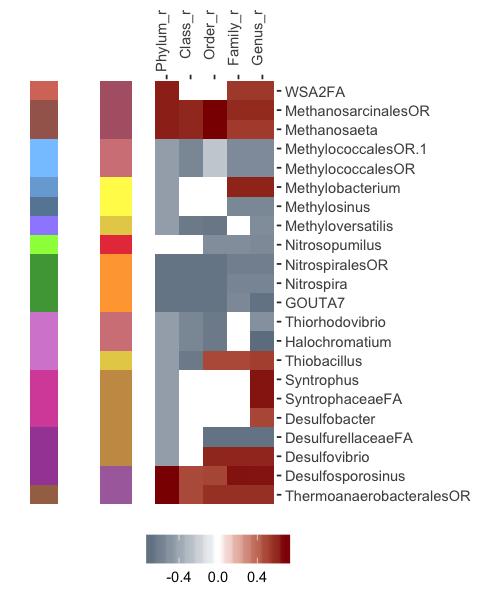

In [43]:
options(repr.plot.width=4, repr.plot.height=5) 
pg_hm

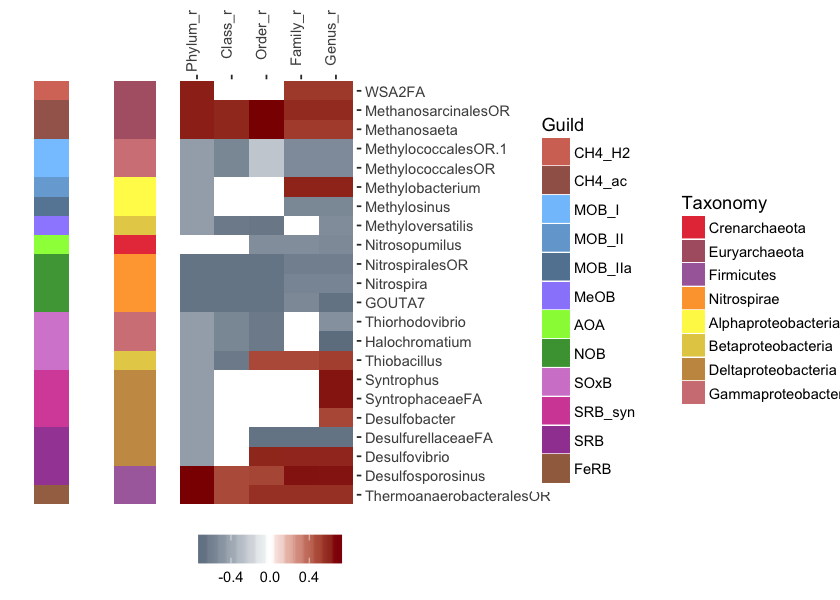

In [44]:
#pg_cols
options(repr.plot.width=7, repr.plot.height=5) 
pg_hmL

In [45]:
# head(Tax_corrU_r)

# Sample abundance heatmaps

### need agg_by_cat function from barplots

In [46]:
# Aggregation test function working

agg_by_cat = function(otu_V, agg_var) {                                                                    
    count_cols <- sapply(otu_V, is.numeric)                              # Select numeric columns
    otu_counts <- data.matrix(otu_V[,count_cols])                        # Keep numeric cols, matrix for phyloseq  #dim(otu_d); head(otu_d)  # head(otu_V); head(otu_d)
    
    agg_fact <- unlist(as.list(otu_V[agg_var]))                          # Get levels for aggregation
    otu_agg <- aggregate(otu_counts, by=list(agg_fact), FUN=sum)         # Aggregate OTU table by agg_fact
    colnames(otu_agg)[1] <- agg_var                                      # rename new groups "Taxa"   # head(otu_agg)
    row.names(otu_agg) <- otu_agg[,1]                                    # set rownames
    return(otu_agg)               
}

# Combined log2 preprocessing for heatmap

In [47]:
# Function to extract Heatmap log2 abundance data
log2_HM_Fabund_data = function(otu_t, filt_otu, agg_var, order_var){ 

    # aggregate OTU table, get filter list by agg_var
    otu_t[agg_var]<-make.unique(as.character(otu_t[,agg_var]))
    
    otu_agg <- agg_by_cat(otu_t, agg_var)                                          # Aggregate to agg_var           (e.g. Genus) 
    otu_f <- data.frame(filt_otu[agg_var])                                         # agg_var levels from OTU filter (e.g. Genus)
    colnames(otu_f) <- agg_var                                                    # rename DF col for agg_var

    # Filter OTU table down 
    otu_agg_f <- merge(otu_f, otu_agg, all.x=TRUE)                                            # slice OTU table using filter df (otu_f)                     
   
    # Separate numeric data and Taxonomy in OTU_table
    count_cols <- sapply(otu_agg_f, is.numeric)                                   # Select numeric columns
    otu_d <- data.frame(otu_agg_f[,count_cols])                                   # Keep numeric cols                      
    Tax_data <- otu_agg_f[(count_cols == FALSE)]                                  # Save taxonomy data                     

    # Fill zero counts with two prior to log2 transform
    otu_d[otu_d==0] <- 2                                                           # replace 0 with 2-- now log2(2) = 0
    row.names(otu_d) <- Tax_data[,1]                                              # add back rownames

    # Log 2 and scale (z-score) data frame
    otu_dL2 <- log2(otu_d)                                                         # log2 all data 
    otu_dL2z <- t(scale(t(otu_dL2)))                                              # Center and scale rows (transpose twice)
    otu_dL2zd <- data.frame(otu_dL2z)                                             # make DF
    otu_dL2zd[agg_var] <- row.names(otu_dL2zd)                                    # add back Genus before merge

    # Get Genus ordering cols, merge
    keepC <- c(agg_var, order_var)#, "G_color")                                    # Get ordering vars to keep
    G_sort <- filt_otu[keepC]                                                      # Get ordering DF
    #G_sort["rev_ord"] <- rev(G_sort[,order_var])
    otu_dL2z_S <- merge(G_sort, otu_dL2zd)                                        # merge ordering, Z-score data

    # Reorder Genus factor after re-paste                                         # drops non-included genera from factor)
    otu_dL2z_S[agg_var] <- factor(otu_dL2z_S[,agg_var])                           # re-paste factor
    #otu_dL2z_S[agg_var] <- reorder(otu_dL2z_S[,agg_var], otu_dL2z_S[,"rev_ord"])  # Reorder Genus factor by G_order
    otu_dL2z_S <- otu_dL2z_S[,-2]                                                 # drop G_order                 
    otu_dL2z_S <- otu_dL2z_S[,-2]                                                 # drop rev_order                 

    return(otu_dL2z_S)
}

In [48]:
# test function to prepare heatmap data
HM_d <-log2_HM_Fabund_data(otu_V, Corr_filt_Guild_Gd, "Genus", "G_order")          # log2_HM_Fabund_data(otu_t, filt_otu, agg_var, order_var)

In [49]:
#head(Corr_filt_Guild_d)
#HM_d <-log2_HM_Fabund_data(otu_V, Corr_filt_Guild_d, "Genus", "order")          # log2_HM_Fabund_data(otu_t, filt_otu, agg_var, order_var)

In [50]:
dim(HM_d); dim(Corr_filt_Guild_Gd)

[1]  22 168

[1] 22 21

In [51]:
#head(HM_d)

In [52]:
#sort_samples_by_meta(otu_F, MetaDB, Sample, index_col)

In [53]:
levels(HM_d$Genus); rev(Corr_filt_Guild_Gd$Genus)

[1] "ThermoanaerobacteralesOR" "Desulfosporosinus"       
 [3] "Desulfovibrio"            "DesulfurellaceaeFA"      
 [5] "Desulfobacter"            "SyntrophaceaeFA"         
 [7] "Syntrophus"               "Thiobacillus"            
 [9] "Halochromatium"           "Thiorhodovibrio"         
[11] "GOUTA7"                   "Nitrospira"              
[13] "NitrospiralesOR"          "Nitrosopumilus"          
[15] "Methyloversatilis"        "Methylosinus"            
[17] "Methylobacterium"         "MethylococcalesOR"       
[19] "MethylococcalesOR.1"      "Methanosaeta"            
[21] "MethanosarcinalesOR"      "WSA2FA"

[1] ThermoanaerobacteralesOR Desulfosporosinus        Desulfovibrio           
 [4] DesulfurellaceaeFA       Desulfobacter            SyntrophaceaeFA         
 [7] Syntrophus               Thiobacillus             Halochromatium          
[10] Thiorhodovibrio          GOUTA7                   Nitrospira              
[13] NitrospiralesOR          Nitrosopumilus           Methyloversatilis       
[16] Methylosinus             Methylobacterium         MethylococcalesOR       
[19] MethylococcalesOR.1      Methanosaeta             MethanosarcinalesOR     
[22] WSA2FA                  
187 Levels: ThermoanaerobacteralesOR Desulfosporosinus ... CrenarchaeotaPH

# Plot log2 abundance heatmap 

In [54]:
log2_abundHM = function(HM_d, heat_cols=def_cols, ylab=T, xlab=F){

    # prepare data (melt, default colors)
    HM_dM <-melt(HM_d)                                                  # melt data before plotting                                                                  
    def_cols <- c("steelblue", "white", "darkred")                      # Get default heatmap colors 
    #def_cols <- c("blue", "white", "red")                      # Get default heatmap colors 

    
    # make ggplot
    p <- ggplot(HM_dM, aes(variable, Genus)) + geom_tile(aes(fill=value))     + 
          scale_fill_gradientn(colours=heat_cols, lim=c(-3,3), na.value = "white") +            

         # Axis params
         theme(axis.title.y = element_blank())                                +            # hide y axis title  
         scale_y_discrete(position="right")  + #,                                                # y labs to right
          #                limits = rev(levels(HM_d[,"Genus"])))               +            # reverse y ordering
         theme(axis.title.x = element_blank())                                +            # hide x axis title                      
         scale_x_discrete(position = "bottom")                                +            # x labs on top
         theme(axis.text.x = element_text(angle = 90, hjust = 1))             +            # rotate x labs 
       
         # Panel params
         theme(panel.background = element_blank(),                                         # Remove panel borders 
           panel.grid.major = element_blank(),                                             # and grid lines  
           panel.grid.minor = element_blank())                                +            # Remove legend entirely
     
         # Legend params
         theme(legend.position = "bottom")                                    +            # legend on bottom
         theme(legend.title = element_blank())                                             # no legend title
        
         ifelse(ylab==T, p <- p,                                                           # hide y labels ? 
                p <- p + theme(axis.text.y=element_blank(),axis.ticks.y=element_blank()))
         ifelse(xlab==T, p <- p,                                                           # hide y labels ? 
                p <- p + theme(axis.text.x=element_blank(),axis.ticks.x=element_blank()))
    p
}

Using Genus as id variables


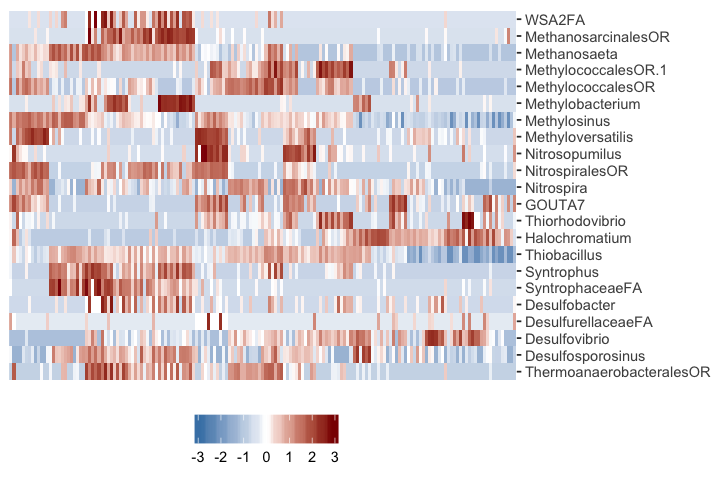

In [55]:
options(repr.plot.width=6, repr.plot.height=4) 
log2_abundHM(HM_d)         #, ylab=F) drops y labels 
#log2_abundHM(HM_d, ylab=F) # drops y labels

In [56]:
## IMPORTANT, here reorder ALL by G_order (cell above) -- Guild ordering,
## by overriding default tax_sort = "Consensus.lineage in corrRanks and Tax colorBar plots

#Tax_heat_corrRanks = function(Taxons3d, Tax_corrU, heatcols){      # uses cowplot::plot_grid 


# Tax_corrU <- Corr_filt_Guild_d
 heat_cols <-grey_red
 #heatcols <- "PiYG"; # heatcols <- "RdGy"

# Get heatmap of corrRanks
Tax_corrU_r <- ggHeat_corrRanks_data(Taxons3d, Corr_filt_Guild_Gd, tax_sort="G_order")           # use function to get corrRanks data
heatRanks <- heatmap_corrRanks(Tax_corrU_r, heat_cols, ylab=F)       # plotting function for heatmap of corrRanks

# Get Taxonomy colorBar
Color_bar_d <- TaxColorBar_dat(Taxons3d, Corr_filt_Guild_Gd, tax_sort="G_order")                 # use function to get Tax colorBar data 
TaxColors <- plot_TaxColorbar(Color_bar_d)                          # plotting function for Tax colorBar

# Split Taxononmy colorBar into no-legend; legend
TaxColors_NL <- TaxColors + theme(legend.position="none")
TaxColors_Legend <-get_legend(TaxColors)

# Get guilds bar
Guild_bar <- Guild_color_bar(Corr_filt_Guild_Gd)
Guild_bar_NL <- Guild_bar + theme(legend.position="none")
Guild_bar_Legend <-get_legend(Guild_bar)

# Get abundance hm
HM_d <-log2_HM_Fabund_data(otu_V, Corr_filt_Guild_Gd, "Genus", "G_order")          # log2_HM_Fabund_data(otu_t, filt_otu, agg_var, order_var)
heat_abund <-log2_abundHM(HM_d, ylab=T)

# Composite plotting of components
pg_hm <- plot_grid(Guild_bar_NL, heatRanks, heat_abund, align="h", ncol=3, rel_widths = c(1,2,8), axis = "rlbt") 
#pg_hm <- plot_grid(Guild_bar_NL, heatRanks, TaxColors_NL, heat_abund, align="h", ncol=4, rel_widths = c(1,2,.7,6), axis = "rlbt") 

pg_hm <- plot_grid(Guild_bar_NL, heatRanks, heat_abund, TaxColors_NL, align="h", ncol=4, rel_widths = c(1.5,3,8,1), axis = "rlbt") 
pg_hm <- plot_grid(Guild_bar_NL, heatRanks, TaxColors_NL, heat_abund,  align="h", ncol=4, rel_widths = c(1.5,3,1,12), axis = "rlbt") 



#pg_hm <- plot_grid(Guild_bar_NL, TaxColors_NL, heatRanks, align="h", ncol=3, rel_widths = c(1,0.7,4), axis = "rlbt") 
#legends <- plot_grid(Guild_bar_Legend, TaxColors_Legend, ncol=2, align = "v", rel_heights = c(1,1), axis = "t")
#pg_hmL <- plot_grid(pg_hm, legends, ncol=2, rel_widths = c(4, 2), align="h", axis = "rl")#, axis = "rlbt")  
 

Using Genus as id variables


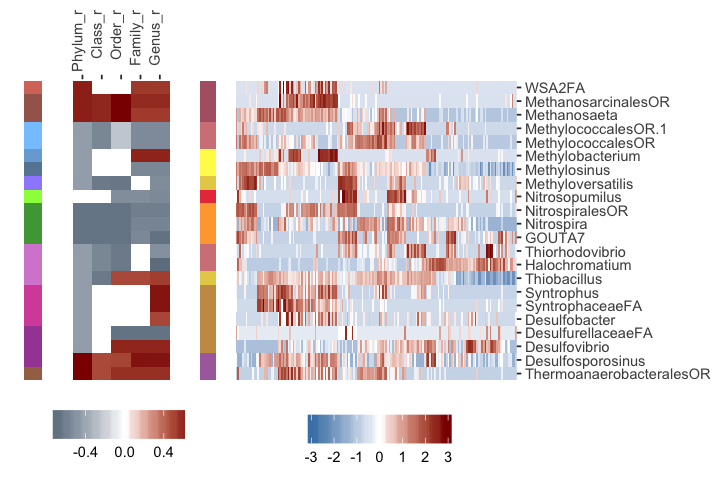

In [57]:
options(repr.plot.width=6, repr.plot.height=4) 
pg_hm

# IMPORTING COLORBAR FXN...etc...made cheaply cleaned barplot module

In [58]:
source('OTU_barplots_module_dev_v3.7_X.R')                # This version has lots of commented out examples
#source('OTU_plotting_module_barplots_DEV_v3.6.r')
# Contains many easter eggs, needs to be properly reduced and documented
#supressMessages()

Using Taxonomy as id variables
Using Taxonomy as id variables
Using Family as id variables
Using Family as id variables
Using Family as id variables
Using Family as id variables


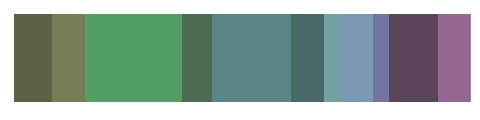

In [59]:
#sb <-site_colbar(Meta_iTag,"Sample", "Location", site_colors, order_var, plot_s)
sb <-site_colbar(Meta_iTag,"Sample", "Location", site_colors, "EWsiteHyd_index", plot="")

options(repr.plot.width=4, repr.plot.height=1)
sb

In [60]:
# Get site color bar
sb <-site_colbar(Meta_iTag,"Sample", "Location", site_colors, "EWsiteHyd_index", plot="")
#sb <-site_colbar(Meta_iTag,"Sample", "Location", site_colors, "EWsiteHyd_index", plot="graph")

# Get abundance hm

HM_d <-log2_HM_Fabund_data(otu_V, Corr_filt_Guild_Gd, "Genus", "G_order")          # log2_HM_Fabund_data(otu_t, filt_otu, agg_var, order_var)

#HM_dS <- sort_otu_agg_by_meta(HM_d, Meta_iTag, "Sample", "CH4_logn1")             # Sort agg by (Fxn. n) on agg

heat_abund <-log2_abundHM(HM_d, ylab=T)

# Composite plotting of components
pg_hm <- plot_grid(sb, heat_abund, align="v", nrow=2, rel_heights = c(1,5), axis = "rlbt") 
#pg_hm <- plot_grid(Guild_bar_NL, heatRanks, TaxColors_NL, heat_abund, align="h", ncol=4, rel_widths = c(1,2,.7,6), axis = "rlbt") 



Using Genus as id variables


In [72]:
# Corr_filt_Guild_Gd

In [71]:
#head(HM_d)

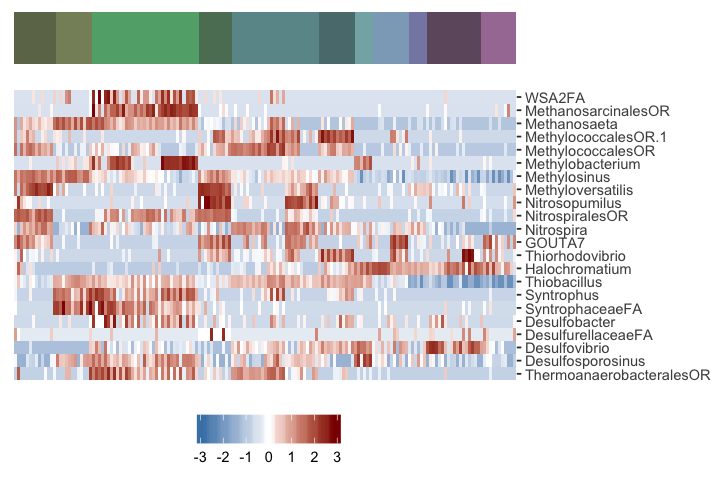

In [61]:
options(repr.plot.width=6, repr.plot.height=4)

pg_hm

In [62]:
# Get guilds bar
Guild_bar <- Guild_color_bar(Corr_filt_Guild_Gd)
Guild_bar_NL <- Guild_bar + theme(legend.position="none")
Guild_bar_Legend <-get_legend(Guild_bar)

Using Genus as id variables


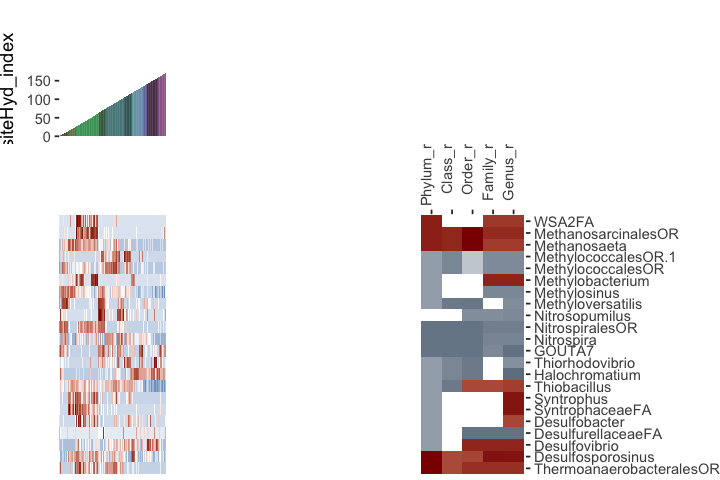

In [63]:
# add guilds bar, match vertical and horiz

#  cowplot::plot_grid(p3, NULL, p1, p2,  ncol = 2, nrow = 2, rel_widths = c(1, 0.75, 1, 0.75), labels = c('A', '', 'C', 'D'), align = "hv"),

sb <-site_colbar(Meta_iTag,"Sample", "Location", site_colors, "EWsiteHyd_index", plot="graph")
sb <-sb + theme(plot.margin = unit(c(0, 0, 0, 0), "cm"))

#heat_abund <- heat_abund + theme(plot.margin = unit(c(0, 0, 0, 0), "cm"), legend.position="none")
TaxColors_NL <- TaxColors_NL + theme(plot.margin = unit(c(0, 0, 0, 0), "cm"))

heat_abund <-log2_abundHM(HM_d, ylab=F)
heat_abund <- heat_abund + theme(plot.margin = margin(r=-5, unit= "cm"), legend.position="none")

heatRanks <- heatmap_corrRanks(Tax_corrU_r, heat_cols, ylab=T, xlab=T)      
#theme(plot.margin = margin(r=-5, unit= "cm")
#heatRanks <- heatRanks + theme(plot.margin = margin(l=-10, unit= "cm"), legend.position="none")
heatRanks <- heatRanks + theme(plot.margin = unit(c(0, -20, 0, 0), "cm"), legend.position="none")

#Guild_bar_NL

#pg_hm3 <- plot_grid(sb, NULL, NULL, heat_abund, heatRanks, Guild_bar_NL, align="hv", ncol = 3, nrow = 2, axis="bt",
   #             rel_widths = c(5,3,2), rel_heights = c(3,7)) 

pg_hm3 <- plot_grid(sb, NULL, heat_abund, heatRanks, align="hv", ncol = 2, nrow = 2, axis="lbtr",
                   rel_widths = c(5,5), rel_heights = c(3,7)) 

#pg_hm3 <- plot_grid(sb, NULL, heat_abund, TaxColors_NL, align="hv", ncol = 2, nrow = 2, axis="bt",
#                  rel_widths = c(5,1), rel_heights = c(1,7)) 


#pg_hm3 <- plot_grid(TaxColors_NL, sb, TaxColors_NL, heat_abund, align="hv", ncol = 2, nrow = 2, axis="bt",
#                   rel_widths = c(1,5), rel_heights = c(2,5)) 


#pg_hm4 <- plot_grid(pg_hm, heat_abund, align="h", ncol = 2, axis="rlbt",
                  # rel_widths = c(6,5))# , rel_heights = c(2,5)) 

#pg_hm <- plot_grid(sb, NULL, heat_abund, Guild_bar_NL, nrow=2, ncol=2, align="hv", axis = "rlbt
#                   rel_widths = c(6,1), rel_heights = c(1,5)) 

options(repr.plot.width=6, repr.plot.height=4)
pg_hm3

In [64]:
library(ggpubr)

Loading required package: magrittr

Attaching package: ‘ggpubr’

The following object is masked from ‘package:cowplot’:

    get_legend



In [65]:
head(HM_d)
#ggtexttable()

Genus,Sandmound_TuleA_D2,Sandmound_TuleB_D1,Sandmound_TuleB_D2,Sandmound_TuleC_D1,Sandmound_TuleC_D2,Sandmound_CattailA_D1,Sandmound_CattailA_D2,Sandmound_ThreeSqA_D1,Sandmound_ThreeSqA_D2,⋯,Muzzi_CordB_D1,Muzzi_CordB_D2,Muzzi_CordC_D1,Muzzi_CordC_D2,Muzzi_PWA_D1,Muzzi_PWA_D2,Muzzi_PWB_D1,Muzzi_PWB_D2,Muzzi_PWC_D1,Muzzi_PWC_D2
Desulfobacter,-0.68686622,-0.6868662,-0.6868662,-0.6868662,-0.6868662,-0.6868662,0.09127211,-0.6868662,-0.6868662,⋯,-0.68686622,-0.68686622,-0.68686622,-0.6868662,-0.6868662,-0.68686622,-0.6868662,-0.6868662,-0.6868662,0.07247608
Desulfosporosinus,-0.10220188,-1.4603667,-1.4603667,-1.4603667,-0.4547885,-0.7889188,-0.82486570,-0.3385245,-1.4603667,⋯,-0.05429784,0.03076264,-0.78741063,-0.8054471,-0.8004988,-0.43042309,-0.3771993,-1.4603667,-1.4603667,-0.84021630
Desulfovibrio,-1.19170291,-1.1917029,-1.1917029,-1.1917029,-1.1917029,-0.4374387,-1.19170291,-1.1917029,-1.1917029,⋯,0.38779034,-0.12001621,-0.05506776,-1.1917029,-0.4504469,-0.03472616,-1.1917029,-1.1917029,-1.1917029,-1.19170291
DesulfurellaceaeFA,0.99589953,3.3844732,-0.3855366,-0.3855366,-0.3855366,-0.3855366,-0.38553663,-0.3855366,-0.3855366,⋯,0.44082859,-0.38553663,-0.38553663,-0.3855366,-0.3855366,-0.38553663,-0.3855366,-0.3855366,-0.3855366,0.92753145
GOUTA7,1.25512238,2.1219056,1.4849472,0.9871277,1.6033714,0.9752105,1.21538144,0.3496116,0.5105747,⋯,1.35167254,2.08613110,0.07682062,1.3348466,-0.2346706,0.48930341,-0.8186536,1.2069711,-0.8186536,1.30407593
Halochromatium,0.09570067,1.6737398,0.6687262,-0.9594913,-0.4800293,0.2959220,-0.50246546,-0.9594913,-0.9594913,⋯,1.94807392,0.67873907,2.06158026,0.7810847,0.7109064,-0.21879877,1.1499843,1.0728164,0.4896069,-0.51350497


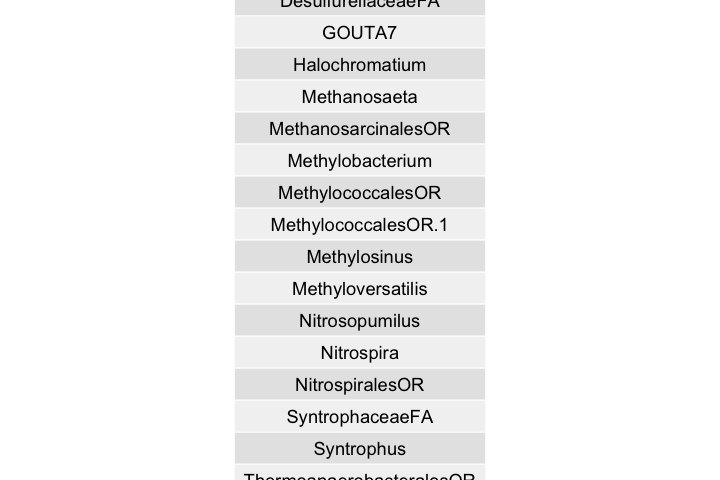

In [66]:
hmg <-HM_d[,1]
tab <-ggtexttable(hmg, rows=NULL)
options(repr.plot.width=6, repr.plot.height=4)
tab

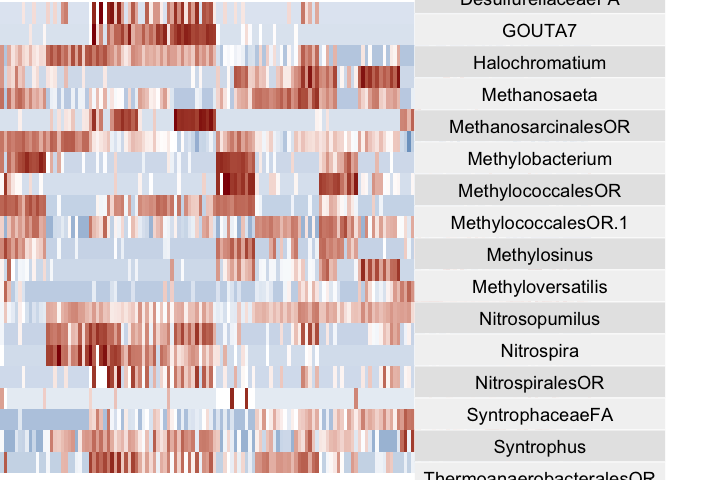

In [67]:
plot_grid(heat_abund, tab, align='h', ncol = 2, axis="lbtr")

# OUTPUT GUILD / Genus data for LASSO 

In [70]:
# Log2 guild data
head(HM_d)

Genus,Sandmound_TuleA_D2,Sandmound_TuleB_D1,Sandmound_TuleB_D2,Sandmound_TuleC_D1,Sandmound_TuleC_D2,Sandmound_CattailA_D1,Sandmound_CattailA_D2,Sandmound_ThreeSqA_D1,Sandmound_ThreeSqA_D2,⋯,Muzzi_CordB_D1,Muzzi_CordB_D2,Muzzi_CordC_D1,Muzzi_CordC_D2,Muzzi_PWA_D1,Muzzi_PWA_D2,Muzzi_PWB_D1,Muzzi_PWB_D2,Muzzi_PWC_D1,Muzzi_PWC_D2
Desulfobacter,-0.68686622,-0.6868662,-0.6868662,-0.6868662,-0.6868662,-0.6868662,0.09127211,-0.6868662,-0.6868662,⋯,-0.68686622,-0.68686622,-0.68686622,-0.6868662,-0.6868662,-0.68686622,-0.6868662,-0.6868662,-0.6868662,0.07247608
Desulfosporosinus,-0.10220188,-1.4603667,-1.4603667,-1.4603667,-0.4547885,-0.7889188,-0.82486570,-0.3385245,-1.4603667,⋯,-0.05429784,0.03076264,-0.78741063,-0.8054471,-0.8004988,-0.43042309,-0.3771993,-1.4603667,-1.4603667,-0.84021630
Desulfovibrio,-1.19170291,-1.1917029,-1.1917029,-1.1917029,-1.1917029,-0.4374387,-1.19170291,-1.1917029,-1.1917029,⋯,0.38779034,-0.12001621,-0.05506776,-1.1917029,-0.4504469,-0.03472616,-1.1917029,-1.1917029,-1.1917029,-1.19170291
DesulfurellaceaeFA,0.99589953,3.3844732,-0.3855366,-0.3855366,-0.3855366,-0.3855366,-0.38553663,-0.3855366,-0.3855366,⋯,0.44082859,-0.38553663,-0.38553663,-0.3855366,-0.3855366,-0.38553663,-0.3855366,-0.3855366,-0.3855366,0.92753145
GOUTA7,1.25512238,2.1219056,1.4849472,0.9871277,1.6033714,0.9752105,1.21538144,0.3496116,0.5105747,⋯,1.35167254,2.08613110,0.07682062,1.3348466,-0.2346706,0.48930341,-0.8186536,1.2069711,-0.8186536,1.30407593
Halochromatium,0.09570067,1.6737398,0.6687262,-0.9594913,-0.4800293,0.2959220,-0.50246546,-0.9594913,-0.9594913,⋯,1.94807392,0.67873907,2.06158026,0.7810847,0.7109064,-0.21879877,1.1499843,1.0728164,0.4896069,-0.51350497


In [82]:
# Genus x Guilds x colors  
#head(Corr_filt_Guild_Gd)

keep_c <- c("Genus", "Guild")#, "G_color")#, "G_index")#, "G_order")
Genus_guild_key <- Corr_filt_Guild_Gd[keep_c]
head(Genus_guild_key)

,Genus,Guild
5,WSA2FA,CH4_H2
7,MethanosarcinalesOR,CH4_ac
6,Methanosaeta,CH4_ac
161,MethylococcalesOR.1,MOB_I
160,MethylococcalesOR,MOB_I
127,Methylobacterium,MOB_II


In [81]:
head(Guild_colors)

Guild,color,G_index
CH4_H2,#CD4F39,1
CH4_ac,#8B3626,2
MOB_I,#63B8FF,3
MOB_II,#4F94CD,4
MOB_IIa,#36648B,5
MeOB,#836FFF,6


In [84]:
# Merge guild key and abundances
CH4_guildG_col_key <- merge(Genus_guild_key, Guild_colors)
CH4_guildG_col_key

Guild,Genus,color,G_index
AOA,Nitrosopumilus,#7CFC00,7
CH4_ac,MethanosarcinalesOR,#8B3626,2
CH4_ac,Methanosaeta,#8B3626,2
CH4_H2,WSA2FA,#CD4F39,1
FeRB,ThermoanaerobacteralesOR,#8B4513,15
MeOB,Methyloversatilis,#836FFF,6
MOB_I,MethylococcalesOR.1,#63B8FF,3
MOB_I,MethylococcalesOR,#63B8FF,3
MOB_II,Methylobacterium,#4F94CD,4
MOB_IIa,Methylosinus,#36648B,5


In [86]:
CH4_guildG_abund_key <- merge(CH4_guildG_col_key, HM_d)
CH4_guildG_abund_key

Genus,Guild,color,G_index,Sandmound_TuleA_D2,Sandmound_TuleB_D1,Sandmound_TuleB_D2,Sandmound_TuleC_D1,Sandmound_TuleC_D2,Sandmound_CattailA_D1,⋯,Muzzi_CordB_D1,Muzzi_CordB_D2,Muzzi_CordC_D1,Muzzi_CordC_D2,Muzzi_PWA_D1,Muzzi_PWA_D2,Muzzi_PWB_D1,Muzzi_PWB_D2,Muzzi_PWC_D1,Muzzi_PWC_D2
Desulfobacter,SRB_syn,#CD2990,12,-0.686866220,-0.6868662,-0.6868662,-0.686866220,-0.68686622,-0.68686622,⋯,-0.68686622,-0.68686622,-0.68686622,-0.6868662,-0.6868662,-0.68686622,-0.68686622,-0.6868662,-0.6868662,0.07247608
Desulfosporosinus,SRB,#8B008B,13,-0.102201875,-1.4603667,-1.4603667,-1.460366682,-0.45478846,-0.78891876,⋯,-0.05429784,0.03076264,-0.78741063,-0.8054471,-0.8004988,-0.43042309,-0.37719932,-1.4603667,-1.4603667,-0.84021630
Desulfovibrio,SRB,#8B008B,13,-1.191702907,-1.1917029,-1.1917029,-1.191702907,-1.19170291,-0.43743866,⋯,0.38779034,-0.12001621,-0.05506776,-1.1917029,-0.4504469,-0.03472616,-1.19170291,-1.1917029,-1.1917029,-1.19170291
DesulfurellaceaeFA,SRB,#8B008B,13,0.995899527,3.3844732,-0.3855366,-0.385536634,-0.38553663,-0.38553663,⋯,0.44082859,-0.38553663,-0.38553663,-0.3855366,-0.3855366,-0.38553663,-0.38553663,-0.3855366,-0.3855366,0.92753145
GOUTA7,NOB,#008B00,9,1.255122378,2.1219056,1.4849472,0.987127692,1.60337138,0.97521054,⋯,1.35167254,2.08613110,0.07682062,1.3348466,-0.2346706,0.48930341,-0.81865357,1.2069711,-0.8186536,1.30407593
Halochromatium,SOxB,#CD69C9,11,0.095700667,1.6737398,0.6687262,-0.959491266,-0.48002927,0.29592196,⋯,1.94807392,0.67873907,2.06158026,0.7810847,0.7109064,-0.21879877,1.14998434,1.0728164,0.4896069,-0.51350497
Methanosaeta,CH4_ac,#8B3626,2,1.129320737,-1.0781382,0.8747712,0.288116111,0.53741544,0.87499430,⋯,-1.07813823,-0.57030800,-1.07813823,-1.0781382,-0.5333817,-1.07813823,-1.07813823,-1.0781382,-1.0781382,-1.07813823
MethanosarcinalesOR,CH4_ac,#8B3626,2,-0.548064776,-0.5480648,-0.5480648,-0.548064776,-0.54806478,-0.54806478,⋯,-0.54806478,-0.54806478,-0.54806478,0.2592705,-0.5480648,-0.54806478,-0.10446351,1.3113284,-0.5480648,-0.54806478
Methylobacterium,MOB_II,#4F94CD,4,-0.539887756,-0.5398878,-0.5398878,-0.539887756,-0.53988776,0.16098299,⋯,-0.53988776,0.10220639,-0.53988776,-0.5398878,-0.5398878,-0.53988776,-0.53988776,-0.5398878,-0.5398878,-0.53988776
MethylococcalesOR,MOB_I,#63B8FF,3,1.571489139,-1.0103122,1.5374305,0.785279809,1.45101771,1.67935373,⋯,-1.01031219,-1.01031219,-1.01031219,-1.0103122,-1.0103122,-1.01031219,-0.44813176,-1.0103122,-1.0103122,-1.01031219


In [87]:
write.table(CH4_guildG_abund_key, "CH4_guildG_log2abund_wkey.txt", sep='\t', col.names=T)